# **8.2 2D Homographies**

A 2D homography is a very general linear transformation between planes. In the previous notebook we applied rotations and translations to 3D points, which are examples of 3D euclidean homographies.

In computer vision, a homography is usually defined as a **perspective transformation of a plane**, in other words, a reprojection of a plane from one camera image into a different one, where the camera may have been translated and/or rotated. As a consequence, **any two images of the same planar surface in space are related by a homography**. This has many practical applications, such as image rectification, image registration, etc. For 2D homographies, we have a $3\times3$ matrix containing the linear transformation:$\\[010pt]$

$$
\begin{bmatrix} a & b & c \\ d & e & f \\ g & h & 1 \end{bmatrix} \begin{bmatrix} x \\ y \\  1\end{bmatrix} 
=  
\begin{bmatrix} u \\ v \\  w\end{bmatrix}\hspace{2cm} \begin{array}{rcr} x' = u\ /\ w \\ y' = v \ / \ w \end{array}\\[5pt] $$ 

<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch8/insert/intro_homography.png" width="400"/>$\\[5pt]$
</center>

Notice that in such transformation:
- Lines are kept straight.
- Incident lines remain.

**In this notebook we will learn:**

- different types of homographies (section 8.2.1).
- how to find the parameters for a given homography in 2D (section 8.2.2).
- under which conditions a homography exists (section 8.2.3).

**This notebook contains <font color=green>5 assignments</font>**

## **Problem context - Homography in american football**

American football is a team sport played by two teams of eleven players on a rectangular field with goalposts at each end. These are some tips about this sport:  

- The offense (the team with possession of the football) has 4 tries (called *downs*) to make the ball advance at least 10 yards (approx 9 meters). 
- If a player passes the **down line** (yellow) with the ball, the offense has another 4 tries to advance 10 more yards (from the point where the football was lost). 
- **On television, a yellow virtual line is superimposed on the field to show the first down line to the viewing audience. Also, a blue line is superimposed showing where the play starts (at the ball).**$\\[10pt]$

<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch8/insert/example_football.jpg" width="500"/>$\\[3pt]$
</center>

As you can see in the image above, the offense is in the **3rd try** to advance 10 yards (they advanced 5 yards in previous tries, so **the objective is now 5 yards**). That information is given by a rectangle placed in the field showing **3rd (try) & 5 (yards to go)**.

Our objective in this notebook is to **place the blue line** (where the ball starts), the **yellow line** (down line) and the placed **rectangle** (which gives to the audience some information) **using homographies**. Let's go for it!

In [15]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [16]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
from math import cos,sin,pi

matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

images_path = '/gdrive/My Drive/Colab Notebooks/Chapter 8. Image Formation/images/'

## **8.2.1 2D homography hierarchy levels**

But let's start from the beginning. All 2D homographies are linear transformation of 2D points, but there is a hierarchy level where we can distinguish different types of homographies (and, hence, transformations):$\\[10pt]$

<center><img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch8/insert/types.png" width="550" /></center>$\\[5pt]$

###**LEVEL 1: Translation**

$$\lambda \begin{bmatrix}x' \\ y' \\ 1 \end{bmatrix} = \begin{bmatrix} 1 & 0 & t_x \\ 0 & 1 & t_y \\ 0 & 0 & 1 \end{bmatrix}\begin{bmatrix}x \\ y \\ 1 \end{bmatrix} = \lambda \begin{bmatrix}x + t_x \\ y + t_y \\ 1 \end{bmatrix}\\[5pt]$$

Translation is the most simple homography, since pixels of the plane are **only shifted** in both $X$ and $Y$ directions.

#### **<font color="green">ASSIGNMENT #1: Playing with translation!</font>**

Your first task is to define a transformation matrix `M` (`float64` numPy matrix) that applies an arbitrary translation to the image `football.jpg`. You can apply a homography to an image using [`cv2.warpPerspective()`](https://docs.opencv.org/4.2.0/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87), which takes as input i) an image, ii) the transformation matrix and iii) the size of the output image. Finally, it shows both the original and the resulting image.

> <font color="orange">**Note:** The output image size depends on the transformation we want to do, but for the following examples you can use the **double of the width and height** of the original image.

For  𝑡𝑥=50  and  𝑡𝑦=100 :


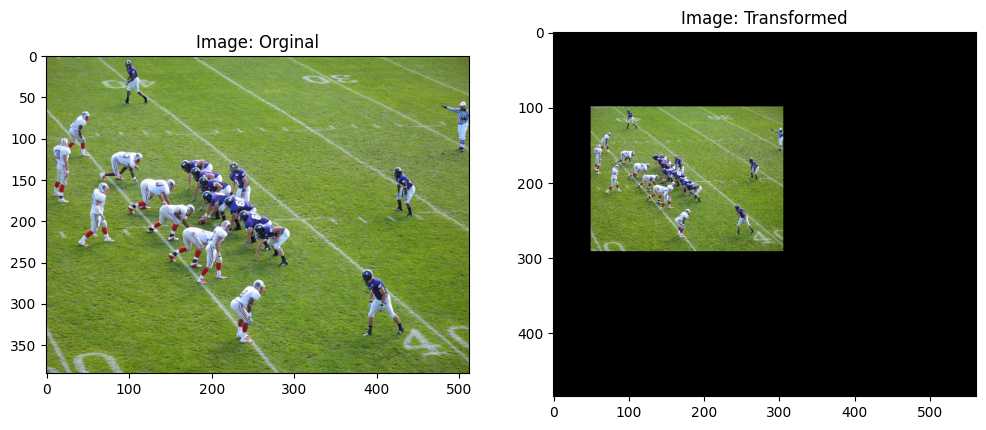

In [70]:
# ASSIGNMENT #1
# Write your code here!
img = cv2.imread(images_path + 'football.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
tx = 50
ty = 100
M = np.array([[0.5, 0, tx],[0, 0.5, ty], [0, 0, 1]], dtype=np.float64)
imgt = cv2.warpPerspective(img, M, (img.shape[1] + tx,img.shape[0] + ty))

print("For  𝑡𝑥=50  and  𝑡𝑦=100 :")
plt.subplot(121)
plt.title('Image: Orginal')
plt.imshow(img)
plt.subplot(122)
plt.title('Image: Transformed')
plt.imshow(imgt)

##### **<font color=red><b>Expected output</b></font>**
For $t_x = 50$ and $t_y = 100$:

<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch8/insert/ch82_a1_result.png" width="500" align="left"/>
</center>

###**LEVEL 2: Euclidean transformation**

$$\lambda \begin{bmatrix}x' \\ y' \\ 1 \end{bmatrix} = \begin{bmatrix} cos(\theta) & -sin(\theta) & t_x \\ sin(\theta) & cos(\theta) & t_y \\ 0 & 0 & 1 \end{bmatrix}\begin{bmatrix}x \\ y \\ 1 \end{bmatrix} = \lambda \begin{bmatrix}cos(\theta)x - sin(\theta)y + t_x \\ sin(\theta)x + cos(\theta)y  + t_y \\ 1 \end{bmatrix}\\[5pt]$$

As we saw in the previous notebook, this homography applies **rotation + translation**.

> <font color="orange">**Note:** The rotation is applied around the origin of coordinates (0,0), which is the top-left corner of the image.

#### **<font color="green">ASSIGNMENT #2: Euclidean transformation comes into play</font>**

Repeat the previous exercise using an Euclidean transformation.

For  𝑡𝑥=400 ,  𝑡𝑦=100  and  𝜃=𝜋4 :


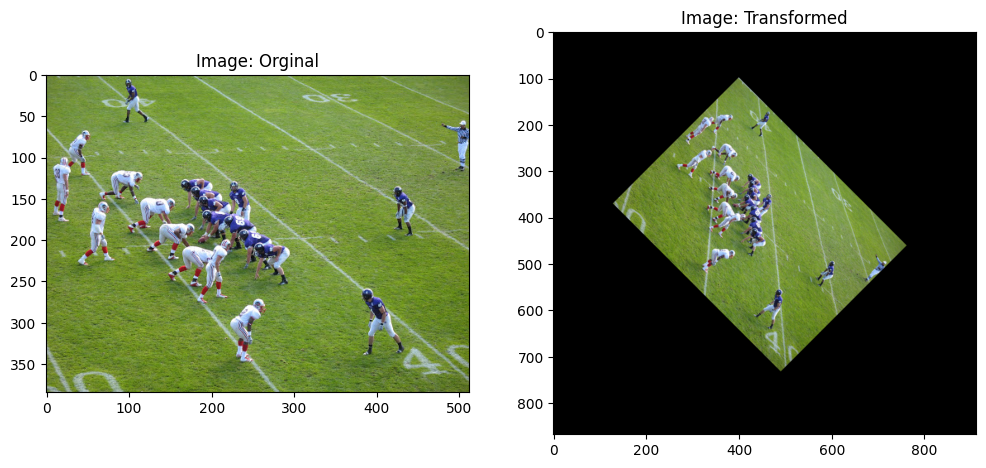

In [69]:
# ASSIGNMENT #2
# Write your code here!

tx = 400
ty = 100
th = pi/4
M = np.array([[cos(th), -sin(th), tx],[sin(th), cos(th), ty], [0, 0, 1]], dtype=np.float64)

imgt = cv2.warpPerspective(img, M, (img.shape[1] + tx,2*img.shape[0] + ty))

print("For  𝑡𝑥=400 ,  𝑡𝑦=100  and  𝜃=𝜋/4 :")
plt.subplot(121)
plt.title('Image: Orginal')
plt.imshow(img)
plt.subplot(122)
plt.title('Image: Transformed')
plt.imshow(imgt)

##### **<font color=red><b>Expected output</b></font>**
For $t_x = 400$, $t_y = 100$ and $\theta = \frac{\pi}{4}$:

<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch8/insert/ch82_a2_result.png" width="500" align="left"/>
</center>

###**LEVEL 3: Similarity**
$$\lambda \begin{bmatrix}x' \\ y' \\ 1 \end{bmatrix} = \begin{bmatrix} s\cdot cos(\theta) & -s\cdot sin(\theta) & t_x \\ s\cdot sin(\theta) & s\cdot cos(\theta) & t_y \\ 0 & 0 & 1 \end{bmatrix}\begin{bmatrix}x \\ y \\ 1 \end{bmatrix} = \lambda \begin{bmatrix}s\cdot (cos(\theta) \cdot x - sin(\theta) \cdot y) + t_x \\ s\cdot (sin(\theta) \cdot x + cos(\theta) \cdot y)  + t_y \\ 1 \end{bmatrix}\\[5pt]$$

This homography applies **rotation + translation + scale**.  
> <font color="orange">**Note:** In this type of homography the scale has to be equal for both axes $x$ and $y$.

### **<font color="green">ASSIGNMENT #3: Applying a similarity transformation</font>**

Repeat the previous exercise using a similarity transformation.

For  𝑡𝑥=300 ,  𝑡𝑦=−50, 𝜃=𝜋/4  and  𝑠=1.5 :


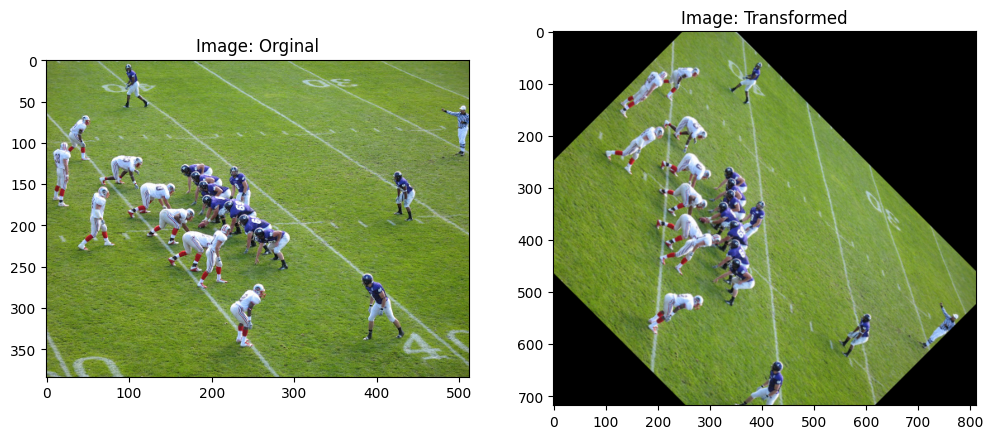

In [71]:
# ASSIGNMENT #3
# Write your code here!
tx = 300
ty = -50
th = pi/4
s = 1.5
M = np.array([[s*cos(th), -s*sin(th), tx],[s*sin(th), s*cos(th), ty], [0, 0, 1]], dtype=np.float64)

imgt = cv2.warpPerspective(img, M, (img.shape[1] + tx,2*img.shape[0] + ty))

print("For  𝑡𝑥=300 ,  𝑡𝑦=−50, 𝜃=𝜋/4  and  𝑠=1.5 :")
plt.subplot(121)
plt.title('Image: Orginal')
plt.imshow(img)
plt.subplot(122)
plt.title('Image: Transformed')
plt.imshow(imgt)

##### **<font color=red><b>Expected output</b></font>**
For $t_x = 300$, $t_y = -50, \theta = \frac{\pi}{4}$ and $s = 1.5$:

<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch8/insert/ch82_a3_result.png" width="500" align="left"/>
</center>

###**LEVEL 4: Affine transformation**

$$\lambda \begin{bmatrix}x' \\ y' \\ 1 \end{bmatrix} = \begin{bmatrix} h_{00} & h_{01} & h_{02} \\ h_{10} & h_{11} & h_{12}\\ 0 & 0 & 1 \end{bmatrix}\begin{bmatrix}x \\ y \\ 1 \end{bmatrix} = \lambda \begin{bmatrix}h_{00}x + h_{01}y + h_{02}\\ h_{10}x + h_{11}y + h_{12}\\ 1 \end{bmatrix}\\[5pt]$$

This is an interesting homography because it appears quite often in real life (e.g. when the depth variation within the planar object and a camera is large):$\\[10pt]$

<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch8/insert/affine.png" width="300" />$\\[5pt]$
</center>

We can deffine it as a **rotation + translation + scale (different for each axis)** transform.

### **<font color="green">ASSIGNMENT #4: Working with affine transformation</font>**

Repeat the previous assignment but using an affine transformation.

For  𝑡𝑥=300 ,  𝑡𝑦= 800 ,𝜃=𝜋/4, 𝑠x=1.5 and sy =0.5:


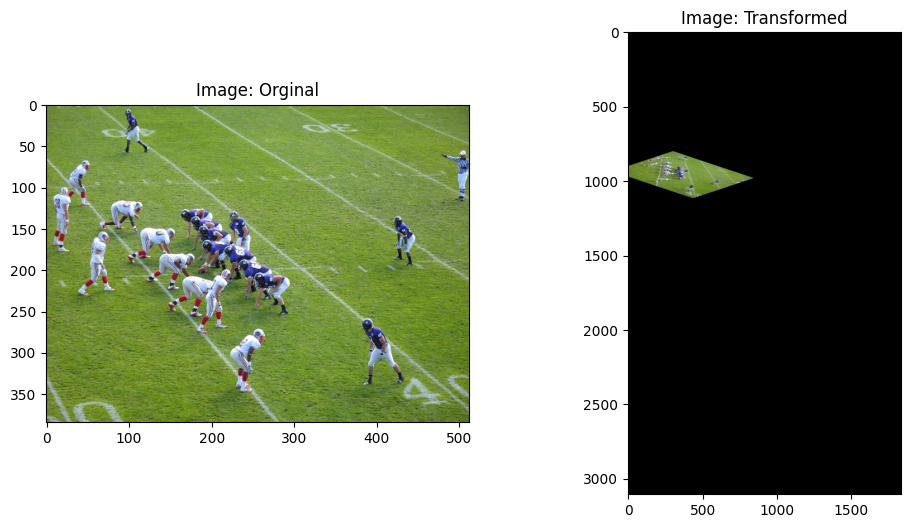

In [80]:
# ASSIGNMENT 4
# Write your code here!
tx = 300
ty = 800
th = pi/4
sx = 1.5
sy = 0.5
M = np.array([[sx*cos(th), -sx*sin(th), tx],[sy*sin(th), sy*cos(th), ty], [0, 0, 1]], dtype=np.float64)

imgt = cv2.warpPerspective(img, M, (3*img.shape[1] + tx,6*img.shape[0] + ty))

print("For  𝑡𝑥=300 ,  𝑡𝑦= 800 ,𝜃=𝜋/4, 𝑠x=1.5 and sy =0.5:")
plt.subplot(121)
plt.title('Image: Orginal')
plt.imshow(img)
plt.subplot(122)
plt.title('Image: Transformed')
plt.imshow(imgt)

##### **<font color=red><b>Expected output</b></font>**
For $t_x = 300$, $t_y = 800$, $\theta = \frac{\pi}{4}, s_x = 1.5$ and $s_y = 0.5$:

<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch8/insert/ch82_a4_result.png" width="500" align="left"/>
</center>

###**LEVEL 5: Projective transformation**

$$\lambda \begin{bmatrix}x' \\ y' \\ 1 \end{bmatrix} = \begin{bmatrix} h_{00} & h_{01} & h_{02} \\ h_{10} & h_{11} & h_{12}\\ h_{20} & h_{21} & 1 \end{bmatrix}\begin{bmatrix}x \\ y \\ 1 \end{bmatrix} = \lambda \begin{bmatrix}h_{00}x + h_{01}y + h_{02}\\ h_{10}x + h_{11}y + h_{12}\\ h_{20}x + h_{21}y + 1 \end{bmatrix}\\[5pt]$$

And we have reached the top level: The projective transformation is the general 2D homography since there are no constraints. Unlike the affine transformation, projective transformations appear in real life when variation in depth is comparable to distance from the camera to an object:$\\[10pt]$

<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch8/insert/comparison_projective.png" width="650" />$\\[5pt]$
</center>

*Note that we used $h_{22}=1$ for fixing the scale factor in linear transformations. This constraint can be replaced with $\textbf{||h|| = 1}$ (better).*  

Projective transformation is a very poweful tool, and it has many applications, **see the following example.**

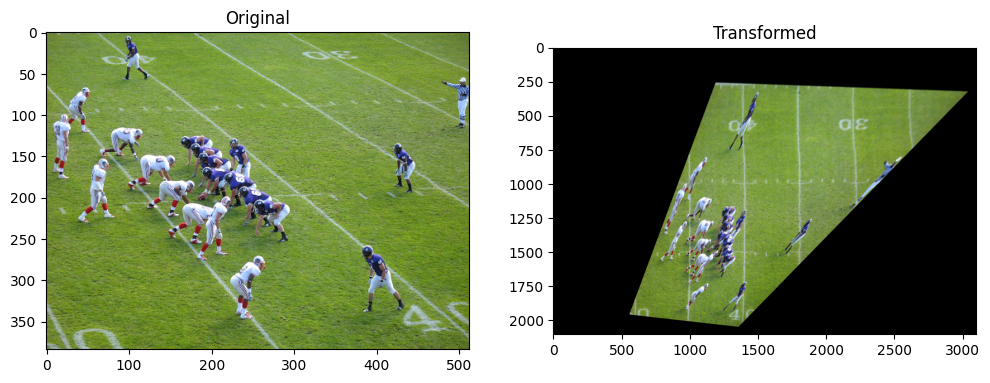

In [83]:
# Define transformation matrix
M = np.array([[     3.1654,   0.03225,1191.14702],
              [  0.0799604,   10.2911,  263.9896],
              [-0.00014621,0.00300344,         1]], dtype=np.float64)

# Apply homography
transformed = cv2.warpPerspective(img, M, (3100,2100))

# Show the resulting image
plt.subplot(121)
plt.title("Original")
plt.imshow(img)
plt.subplot(122)
plt.title("Transformed")
plt.imshow(transformed);

As you can see, the perspective of the image has been **removed** and the resultant image is *like* an image taken from the air.

But, you can see that the coefficient of the employed matrix are not some randomly picked numbers, so how can you obtain the specific matrix `M` that is able to do this? The short answer is from a set of corresponding points (rings any bell?). And going one step further: **How can a matrix `M` be obtained having pairs of correspondences**?  

Just as a preview, in the example above, we have used the four corners of the rectangle that the white lines are forming and we have made them to correspond with an actual rectangle without perspective. Do not worry, we will explain this later, but first let's have a look at the maths behind this.

## **8.2.2 Solving the 2D homography in code: Direct Lineal Transformation (DLT)**

As you know, a general 2D homography that converts a point $p=(x,y)$ to another point $p'=(x',y')$ looks like this (in homogeneous coordinates):$\\[5pt]$

$$\lambda \begin{bmatrix}x' \\ y' \\ 1 \end{bmatrix} = \begin{bmatrix} h_{00} & h_{01} & h_{02} \\ h_{10} & h_{11} & h_{12}\\ h_{20} & h_{21} & 1 \end{bmatrix}\begin{bmatrix}x \\ y \\ 1 \end{bmatrix}$$

If we know the coordinates of the corresponding points in both images, we can build an equation system to solve the coefficients of the matrix. 
    
If you know the specific type of the transformation, you will need a different minimum number of points to solve this equation system:

- **Translation** (2 unknowns) $\rightarrow$ **1 pair of points needed**
- **Euclidean** (3 unknowns) $\rightarrow$ **2 pair of points needed**
- **Similarity** (4 unknowns) $\rightarrow$ **2 pair of points needed**
- **Affine** (6 unknowns) $\rightarrow$ **3 pair of points needed**
- **Projective** (8 unknowns) $\rightarrow$ **4 pair of points needed**

Usually, though, you will need many more points for noise robustness (the more the merrier, as they say).  

Finally, each type of transformation entails certain transformations and invariance, as summarized in this table:$\\[10pt]$

<table>
<tbody>
<tr style="height: 23px;border: 1px solid black;">
<th style="height: 23px;border: 1px solid black;">&nbsp;</td>
<th style="height: 23px;border: 1px solid black;">Euclidean </td>
<th style="height: 23px;border: 1px solid black;">&nbsp;Similarity</td>
<th style="height: 23px;border: 1px solid black;">&nbsp;Affine</td>
<th style="height: 23px;border: 1px solid black;">&nbsp;Projective</td>
</tr>
<tr style="height: 23px;border: 1px solid black;">
<th style="height: 23px;border: 1px solid black;">&nbsp;Transformations:</td>
<td style="height: 23px;">&nbsp;</td>
<td style="height: 23px;">&nbsp;</td>
<td style="height: 23px;">&nbsp;</td>
<td style="height: 23px;">&nbsp;</td>
</tr>
<tr style="height: 23px;border: 1px solid black;">
<td style="height: 23px;border: 1px solid black;">&nbsp;Rotation, translation</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;x</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;x</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;x</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;x</td>
</tr>
<tr style="height: 23px;border: 1px solid black;">
<td style="height: 23px;border: 1px solid black;">&nbsp;Isotropic scale</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;x</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;x</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;x</td>
</tr>
<tr style="height: 23px;border: 1px solid black;">
<td style="height: 23px;border: 1px solid black;">&nbsp;Axes scale</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;x</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;x</td>
</tr>
<tr style="height: 23px;border: 1px solid black;">
<td style="height: 23px;border: 1px solid black;">&nbsp;Perspective transformation</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;x</td>
</tr>
<tr style="height: 23px;border: 1px solid black;">
<th style="height: 23px;border: 1px solid black;">&nbsp;Invariants:</td>
<td style="height: 23px;">&nbsp;</td>
<td style="height: 23px;">&nbsp;</td>
<td style="height: 23px;">&nbsp;</td>
<td style="height: 23px;">&nbsp;</td>
</tr>
<tr style="height: 23px;border: 1px solid black;">
<td style="height: 23px;border: 1px solid black;">&nbsp;Distance</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;x</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;</td>
</tr>
<tr style="height: 23px;border: 1px solid black;">
<td style="height: 23px;border: 1px solid black;">&nbsp;Angles, distance ratios</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;x</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;x</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;</td>
</tr>
<tr style="height: 23px;border: 1px solid black;">
<td style="height: 23px;border: 1px solid black;">Parallelism, mass center</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;x</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;x</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;x</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;</td>
</tr>
<tr style="height: 23px;border: 1px solid black;">
<td style="height: 23px;border: 1px solid black;">&nbsp;Cross-ratio</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;x</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;x</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;x</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;x</td>
</tr>
</tbody>
</table>

### **<font color="green">ASSIGNMENT 5a: Let's apply your knowledge</font>**

Now that we know how to solve the homography 2D, let's go back to our American football problem.

We are going to work with the image `football-big.jpg`, which is the same as the one used in previous exercises but with a better resolution and quality.

Let's start by reading and showing such color image in RGB:

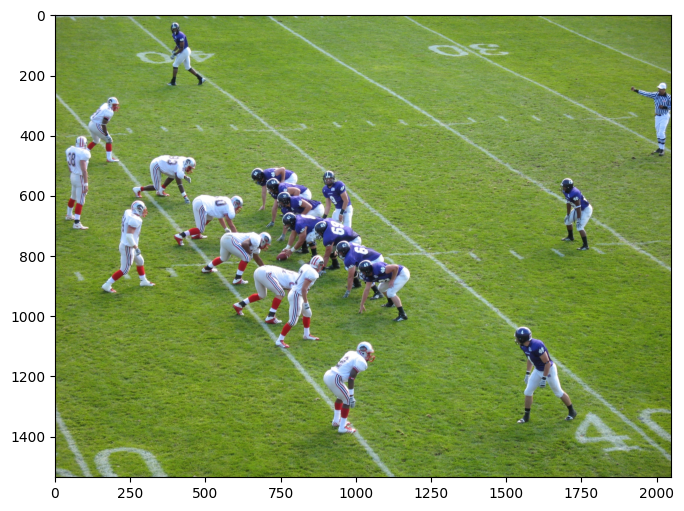

In [84]:
# ASSIGNMENT #5a
# Write your code here!
img = cv2.imread(images_path + 'football-big.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

##### **<font color=red><b>Expected output</b></font>**

<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch8/insert/ch82_a5a_result.png" width="500" align="left"/>
</center>

Our first task is to add the image `marker.jpg` to the field. 

<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch8/insert/marker.jpg" width="150" />$\\[5pt]$
</center>

For adding an image without perspective to an image with perspective, the first step is to **remove the perspective** of the original image, and for that we are going to *map* the points of a rectangle on the field to **an actual rectangle**, but keeping the ratio of the sides' lengths of the rectangle (remember that a projective transformation is only invariant to the cross-ratio distances!):

<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch8/insert/points-homography.png" width="800" />$\\[5pt]$
</center>

Now that we have four (manually selected) corresponding points, and now we are going to compute the transformation matrix of that projective homography. This is easy in openCV, as it provides the [`cv2.findHomography()`](https://docs.opencv.org/4.2.0/d9/d0c/group__calib3d.html#ga4abc2ece9fab9398f2e560d53c8c9780) method, which takes two lists of corresponding points as input: the first list contains the input coordinates $(x_i,y_i)$ and the second list their correspondences $(x'_i,y'_i)$.

> <font color="orange">**Note:** These points represent image coordinates, so their format is $(col, row)$.

### **<font color="green">ASSIGNMENT 5b: Obtaining the transformation matrix</font>**

Take the **four corners of the specified rectangle** (you can use an external tool to get the coordinates) and obtain the transformation matrix that removes the perpective of the football field. Then **use `warpPerspective()` with the obtained matrix** to remove the perspective and **show the image**. Finally, save it into your computer, we will need it for the next exercise.

> <font color="orange">**Note:** Remember that the output rectangle should maintain the ratio of the original football field ($10\ /\ 6.16$) when you define the list of the correspondent points, and for computation purposes use numbers that are "similar" in size!.

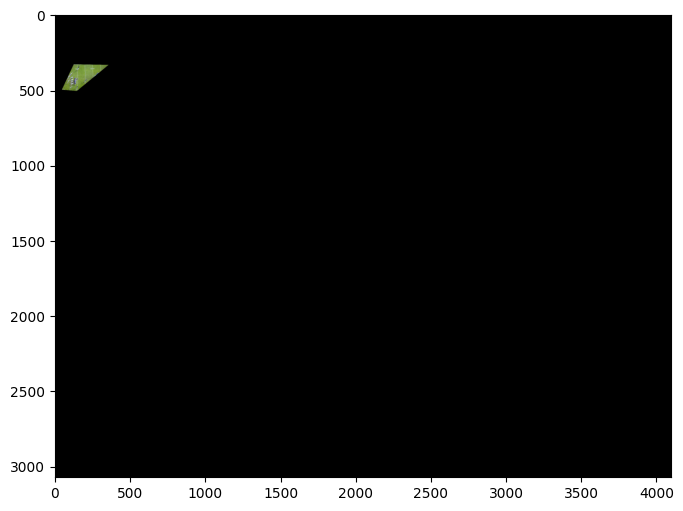

In [119]:
# ASSIGNMENT #5b
# Write your code here!
l_1 = np.array([[125, 397],[1290, 366],[1905, 758],[512, 826]])
l_2 = np.array([(100,400),(200, 400), (200,450), (100,450)])
M, mask = cv2.findHomography(l_1, l_2)

imgt = cv2.warpPerspective(img, M, (2*img.shape[1], 2*img.shape[0]))
plt.imshow(imgt)

##### **<font color=red><b>Expected output</b></font>**
**Parameters**:

Origin of the rectangle: $$(o_x,o_y) = (1000,1000)$$
Size ratio: $$r = 10/6.16 ≈ 1.62$$
Size of the rectangle: $$(s_x,s_y) = (500\cdot r, 500)$$ 

<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch8/insert/ch82_a5b_result.png" width="500" align="left"/>
</center>

Now that we have the field without perspective, we can add the marker to the image in any place.

As we want to **add the start and down line in the original image**, we need to **take two points for each line in this image** (note that now the lines are vertical lines, so take points with the same $x$ coordinate for both lines). In the next exercise we will apply inverse homography to those points so it will be possible to draw the line in the original image. **The down line should be at 3 yards of the start line** (each small vertical segment marks one yard, and vertical lines mark five yards).

### **<font color="green">ASSIGNMENT 5c: Adding the marker</font>**

Add the marker to the image without perspective and show it. Also take the points mentioned before. The resulting image should look like this:$\\[5pt]$

<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch8/insert/marker-example.png" width="600" />$\\[5pt]$
</center>

100


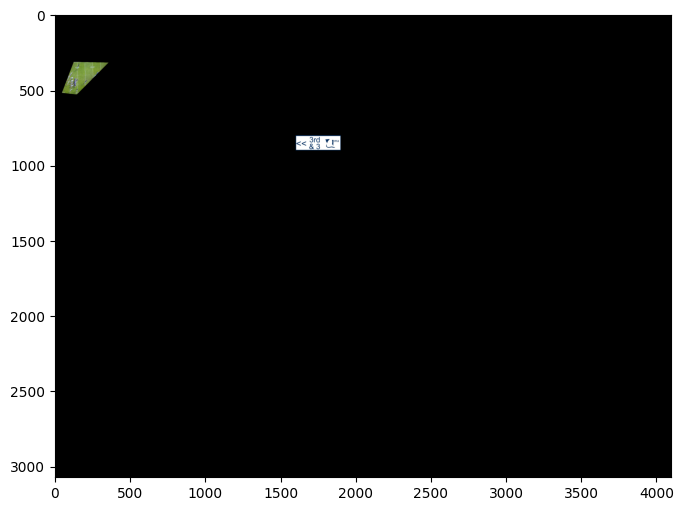

In [89]:
# ASSIGNMENT #5c
# Write your code here!
marker = cv2.imread(images_path + 'marker.jpg', -1)
marker = cv2.cvtColor(marker, cv2.COLOR_BGR2RGB)
print(marker.shape[0])
imgt[800:800 + marker.shape[0], 1600:1600 + marker.shape[1]] = marker
plt.imshow(imgt)

It's time to restore the initial perspective. For that **apply the homography using the inverse of the transformation matrix**:

$$\lambda \begin{bmatrix}x \\ y \\ 1 \end{bmatrix} = \begin{bmatrix} h_{00} & h_{01} & h_{02} \\ h_{10} & h_{11} & h_{12}\\ h_{20} & h_{21} & 1 \end{bmatrix}^{-1}\begin{bmatrix}x' \\ y' \\ 1 \end{bmatrix}$$

### **<font color="green">ASSIGNMENT 5d: Going back to the initial perspective, but with the mark!</font>**

Compute the inverse of the transformation matrix using [`numpy.linalg.inv()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.inv.html), and bring back the perspective to the image with the marker using the new homography and show it.

> <font color="orange">**Note:** You should see the marker having the same perspective than the original image.

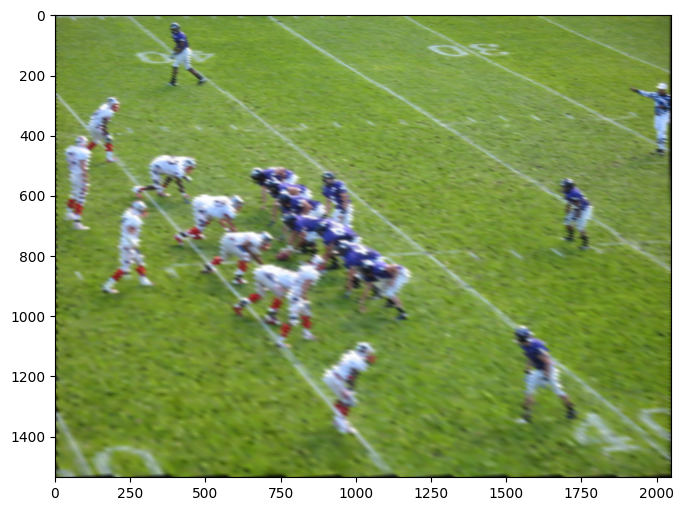

In [91]:
# ASSIGNMENT #5d
# Write your code here!
Minv=np.linalg.inv(M)
img1 = cv2.warpPerspective(imgt, Minv, (img.shape[1], img.shape[0]))
plt.imshow(img1)

Finally, its time to **draw the lines**. You should have saved the coordinates of two points for each line in the image without perspective.

For homography of lines, you just need to **apply the homography to two points of the line**. In that way, you will have two points in the original image defining the line.

Note that `cv2.line()` has two points as input, but only draws the segment line. You will have to **extend that segment** using the slope of the line.

$$slope = \frac{y_2-y_1}{x_2-x_1}$$

The new points will be:

$$\begin{eqnarray}
x'_1,\ \  y'_1 = x_1 + extension,\ \ y_1 + extension\times slope\\[3pt]
x'_2,\ \  y'_2 = x_2 - extension,\ \  y_2 - extension\times slope
\end{eqnarray}$$

### **<font color="green">ASSIGNMENT 5e: Drawing the lines</font>**

Apply the **inverse homography** to the line points, **extend** the line segment and **draw** the start line (blue) and the down line (yellow). Finally, show the resulting image.

This resulting image should look like this:$\\[5pt]$

<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch8/insert/result.png" width="500" />$\\[5pt]$
</center>

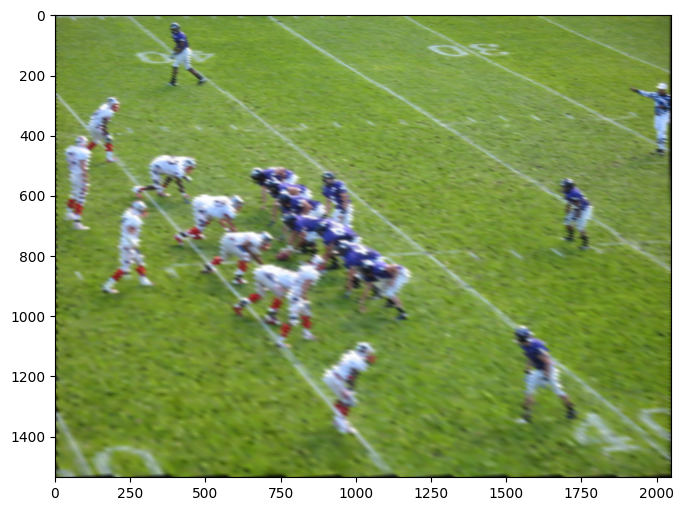

In [97]:
# ASSIGNMENT #5e
# Write your code here!

p1 = (900, 2000,1)
p2 = (900, 1500,1)
p1= Minv@p1
p2= Minv@p2
p1 = (np.int32(p1[0]/p1[2]), np.int32(p1[1]/p1[2]))
p2 = (np.int32(p2[0]/p2[2]), np.int32(p2[1]/p2[2]))

slope= (p2[1] - p1[1])/(p2[0] - p1[0])
extension=1500

p1 = (p1[0]+extension, p1[1]+extension*slope)
p2 = (p2[0]-extension, p2[1]-extension*slope)
p1 = (np.int64(p1[0]), np.int64(p1[1]))
p2 = (np.int64(p2[0]), np.int64(p2[1]))
lines1=cv2.line(img1,p1,p2,(255, 255, 0),5)

p1 = (1200,900,1)
p2 = (1200,1600,1)
p1= Minv@p1
p2= Minv@p2
p1 = (np.int64(p1[0]/p1[2]), np.int64(p1[1]/p1[2]))
p2 = (np.int64(p2[0]/p2[2]), np.int64(p2[1]/p2[2]))

slope= (p2[1] - p1[1])/(p2[0] - p1[0])

p1 = (p1[0]+extension, p1[1]+extension*slope)
p2 = (p2[0]-extension, p2[1]-extension*slope)
p1 = (np.int64(p1[0]), np.int64(p1[1]))
p2 = (np.int64(p2[0]), np.int64(p2[1]))
lines2=cv2.line(lines1,p1,p2,(0, 0, 255),5)

plt.imshow(lines1)
plt.imshow(lines2)

## **Conclusion**

Fantastic work! Homographies are a very important tool in computer vision. In this notebook you have learned:

- what a homography is, how to solve it and how to apply it,
- how to apply homographies to lines,
- some homography applications that are currently being used in American football (and other sports too! think about placing advertising on a tennis or football field).